# Network training and dversarial attack pipeline

This notebook goes through the training of a simple convolutional neural network against which an adversarial attack will be executed and evaluated. MNIST dataset is used for both the network training and evaluation and the attack optimizer evaluation.

The pipeline here tackled is as follows:
1. Environment setup: dependencies, Google Colaboratory setup, etc.
2. Dataset loading: read MNIST dataset from file
3. Network training and evaluation: tune the correct weights in order to perform digits classification
4. Network attack and evaluation: perform an adversarial attack according to the chosen optimization method and evaluate its performances

Note: keeping the network architecture simple and the choosen MNIST dataset allow the pipeline to be run with relatively low computational resources.

## Environment setup

In [1]:
# Google Colaboratory optional setup

# Common dependencies
import sys
import os

# # Import google file system dependency
# from google.colab import drive
# # Mount remote file system
# drive.mount('content/drive')
# # Set remote working directory
# os.chdir('content/drive/path/to/remote/root')

In [2]:
# Default setup

# Custom dependencies
from src.loss import MSELoss, ZooLoss
from src.optim.fw import FrankWolfe
# from src.optim.zero import ZeroOptim
from src.dataset import MNIST
from src.models import MnistNet

# Common dependencies
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Torch dependencies
from torchvision import transforms
import torch
# from torch import nn, optim

In [3]:
# Devices setup

# Get reference to CPU (default device)
cpu = torch.device('cpu')
# Get best device (GPU if available, otherwise defaults to cpu)
device = torch.device('cuda') if torch.cuda.is_available() else cpu

## Dataset loading

In [4]:
# Load MNIST dataset
# Note: standard/detault transformation just parses input data to torch.Tensor
mnist = MNIST(transform='default')
# Split MNIST dataset in train and test datasets
train, test = mnist.get_dataloader(batch_size=250, num_workers=0)


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


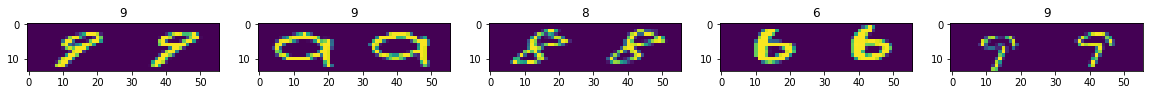

In [5]:
# Get training dataset info
MNIST.get_info(train)


Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([250, 1, 28, 28])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([250])


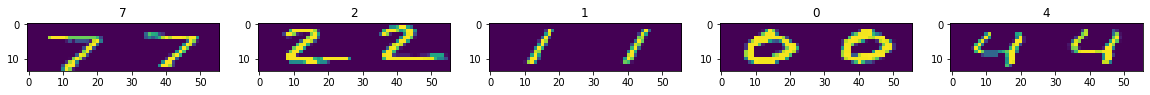

In [6]:
# Get test dataset info
MNIST.get_info(test)

## Network

In [7]:
# Instantiate new neural network with given 
net = MnistNet()
# Load pre-trained weights
net.load_state_dict(torch.load('models/mnistBaseV2_state_dict.pth'))
# Move network to selected device
net.to(device)
# Set network in evaluation mode (avoid gradient calculation)
net.eval()

MnistNet(
  (FeatureExtractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 20, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(20, 24, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Classifier): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1536, out_features=256, bias=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

## Attack

### Single example attack

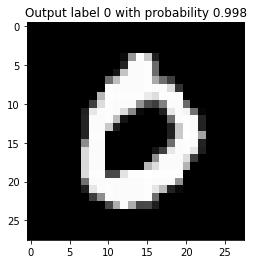

In [8]:
# Get first available test batch
batch = next(iter(test))
# Get X input and y target
X, y = batch[0], batch[1]
# Move either X and Y to selected device
X = X.to(device)
y = y.to(device)

# Get the third image
img = X[3].cpu().numpy()
# Define output function
out_fn = torch.nn.Softmax(dim=1)
# Compute network output through output function
out = out_fn(net(X[3].reshape(1, 1, 28, 28)))
# Get image's label
label_true = torch.argmax(out).item()
# Plot image
_ = plt.imshow(np.transpose(img, (1, 2, 0)).reshape(28, 28), cmap='gray')
# Add title
_ = plt.title('Output label {0:d} with probability {1:.3f}'.format(
    # Original label
    int(label_true),
    # Original label probability
    float(out[0, label_true]))
)
# Show plot
_ = plt.show()

  2%|▏         | 2/100 [00:00<00:11,  8.50it/s]

Current x
 tensor([[[ 3.0000e-06, -3.0000e-06, -3.0000e-06, -3.0000e-06, -3.0000e-06,
           3.0000e-06,  3.0000e-06, -3.0000e-06,  3.0000e-06,  3.0000e-06,
           3.0000e-06,  3.0000e-06,  3.0000e-06,  3.0000e-06,  3.0000e-06,
           3.0000e-06,  3.0000e-06, -3.0000e-06,  3.0000e-06,  3.0000e-06,
           3.0000e-06,  3.0000e-06,  3.0000e-06,  3.0000e-06, -3.0000e-06,
           3.0000e-06, -3.0000e-06,  3.0000e-06],
         [-3.0000e-06, -3.0000e-06,  3.0000e-06,  3.0000e-06,  3.0000e-06,
           3.0000e-06,  3.0000e-06,  3.0000e-06,  3.0000e-06,  3.0000e-06,
           3.0000e-06,  3.0000e-06, -3.0000e-06,  3.0000e-06,  3.0000e-06,
           3.0000e-06,  3.0000e-06,  3.0000e-06,  3.0000e-06,  3.0000e-06,
           3.0000e-06, -3.0000e-06,  3.0000e-06,  3.0000e-06, -3.0000e-06,
           3.0000e-06, -3.0000e-06,  3.0000e-06],
         [-3.0000e-06, -3.0000e-06, -3.0000e-06, -3.0000e-06,  3.0000e-06,
           3.0000e-06, -3.0000e-06,  3.0000e-06,  3.0000e-06,  3

  4%|▍         | 4/100 [00:00<00:11,  8.43it/s]

Current x
 tensor([[[-3.0003e-06, -8.9991e-06, -8.9991e-06, -2.9991e-06, -2.9991e-06,
           2.9991e-06,  2.9991e-06, -2.9997e-06,  2.9997e-06,  8.9991e-06,
           8.9991e-06,  8.9991e-06,  8.9991e-06,  8.9991e-06,  8.9991e-06,
           8.9991e-06,  8.9991e-06,  3.0003e-06,  8.9991e-06,  8.9991e-06,
           8.9991e-06,  8.9991e-06,  8.9991e-06,  8.9991e-06, -2.9991e-06,
           8.9991e-06, -2.9991e-06,  2.9991e-06],
         [-8.9991e-06, -8.9991e-06,  2.9991e-06,  8.9991e-06,  8.9991e-06,
           8.9991e-06,  8.9991e-06,  8.9991e-06,  8.9991e-06,  8.9991e-06,
           8.9991e-06,  2.9991e-06,  3.0003e-06,  8.9991e-06,  8.9991e-06,
           8.9991e-06,  8.9991e-06,  8.9991e-06,  8.9991e-06,  8.9991e-06,
           8.9991e-06,  3.0003e-06, -3.0003e-06,  8.9991e-06,  3.0003e-06,
           2.9991e-06,  3.0003e-06,  2.9997e-06],
         [-8.9991e-06, -8.9991e-06, -2.9997e-06, -8.9991e-06, -3.0003e-06,
          -3.0003e-06,  3.0003e-06,  8.9991e-06,  2.9997e-06,  2

  6%|▌         | 6/100 [00:00<00:11,  8.51it/s]

Current x
 tensor([[[-8.9994e-06, -8.9970e-06, -8.9976e-06,  3.0012e-06,  3.0012e-06,
           2.9988e-06, -3.0012e-06, -2.9988e-06,  2.9988e-06,  1.4997e-05,
           1.4997e-05,  1.4997e-05,  8.9976e-06,  1.4997e-05,  1.4997e-05,
           1.4997e-05,  1.4997e-05,  8.9994e-06,  1.4997e-05,  1.4997e-05,
           1.4997e-05,  8.9976e-06,  1.4997e-05,  8.9970e-06, -8.9982e-06,
           1.4997e-05, -8.9982e-06, -3.0012e-06],
         [-1.4997e-05, -1.4997e-05,  2.9988e-06,  1.4997e-05,  1.4997e-05,
           1.4997e-05,  1.4997e-05,  1.4997e-05,  8.9970e-06,  8.9976e-06,
           1.4997e-05,  8.9982e-06,  8.9994e-06,  1.4997e-05,  1.4997e-05,
           1.4997e-05,  1.4997e-05,  1.4997e-05,  1.4997e-05,  8.9976e-06,
           1.4997e-05,  8.9994e-06,  3.0000e-06,  1.4997e-05,  8.9994e-06,
           8.9982e-06,  8.9994e-06,  2.9988e-06],
         [-1.4997e-05, -1.4997e-05, -2.9988e-06, -1.4997e-05, -2.9994e-06,
           3.0000e-06, -3.0000e-06,  8.9976e-06,  8.9988e-06,  2

  8%|▊         | 8/100 [00:00<00:11,  8.32it/s]

Current x
 tensor([[[-1.4997e-05, -8.9955e-06, -1.4995e-05,  3.0003e-06,  9.0003e-06,
          -3.0015e-06, -9.0003e-06,  3.0015e-06, -3.0015e-06,  2.0994e-05,
           1.4994e-05,  2.0994e-05,  1.4995e-05,  2.0994e-05,  2.0994e-05,
           2.0994e-05,  1.4994e-05,  1.4997e-05,  2.0994e-05,  2.0994e-05,
           1.4994e-05,  1.4995e-05,  2.0994e-05,  8.9955e-06, -1.4996e-05,
           8.9943e-06, -8.9967e-06, -9.0003e-06],
         [-2.0994e-05, -1.4994e-05, -3.0015e-06,  1.4994e-05,  2.0994e-05,
           2.0994e-05,  2.0994e-05,  2.0994e-05,  8.9949e-06,  1.4995e-05,
           2.0994e-05,  1.4996e-05,  1.4997e-05,  2.0994e-05,  2.0994e-05,
           2.0994e-05,  2.0994e-05,  2.0994e-05,  2.0994e-05,  8.9955e-06,
           2.0994e-05,  1.4997e-05,  2.9997e-06,  2.0994e-05,  2.9979e-06,
           1.4996e-05,  1.4997e-05, -3.0015e-06],
         [-2.0994e-05, -8.9943e-06, -2.9979e-06, -2.0994e-05, -2.9985e-06,
           8.9991e-06, -2.9997e-06,  1.4995e-05,  1.4997e-05, -3

 10%|█         | 10/100 [00:01<00:10,  8.34it/s]

Current x
 tensor([[[-1.4994e-05, -1.4993e-05, -8.9928e-06,  2.9994e-06,  2.9988e-06,
          -9.0006e-06, -8.9982e-06,  9.0006e-06, -3.0012e-06,  2.6989e-05,
           1.4991e-05,  2.6989e-05,  2.0992e-05,  2.6989e-05,  2.6989e-05,
           2.6989e-05,  2.0991e-05,  2.0994e-05,  2.6989e-05,  2.6989e-05,
           1.4991e-05,  1.4992e-05,  2.0990e-05,  8.9934e-06, -8.9934e-06,
           2.9928e-06, -1.4995e-05, -1.4998e-05],
         [-2.6989e-05, -8.9910e-06,  2.9988e-06,  2.0990e-05,  2.0990e-05,
           2.6989e-05,  2.0989e-05,  1.4990e-05,  8.9928e-06,  2.0992e-05,
           2.6989e-05,  2.0993e-05,  2.0994e-05,  2.6989e-05,  2.0989e-05,
           1.4990e-05,  2.6989e-05,  2.6989e-05,  2.6989e-05,  8.9940e-06,
           2.0989e-05,  2.0994e-05,  8.9988e-06,  2.6989e-05,  2.9976e-06,
           1.4993e-05,  2.0994e-05, -9.0006e-06],
         [-2.6989e-05, -2.9928e-06, -8.9970e-06, -1.4990e-05, -2.9976e-06,
           1.4997e-05, -2.9994e-06,  2.0992e-05,  2.0993e-05, -3

 12%|█▏        | 12/100 [00:01<00:10,  8.31it/s]

Current x
 tensor([[[-1.4991e-05, -1.4991e-05, -8.9907e-06,  8.9985e-06, -3.0015e-06,
          -8.9985e-06, -1.4996e-05,  8.9991e-06,  2.9991e-06,  3.2984e-05,
           1.4988e-05,  3.2984e-05,  2.6988e-05,  3.2984e-05,  3.2984e-05,
           3.2984e-05,  2.6987e-05,  2.6989e-05,  3.2984e-05,  3.2984e-05,
           1.4988e-05,  2.0989e-05,  2.0985e-05,  8.9913e-06, -2.9919e-06,
          -3.0075e-06, -2.0991e-05, -2.0995e-05],
         [-3.2984e-05, -8.9895e-06, -3.0015e-06,  2.6986e-05,  2.6985e-05,
           2.0984e-05,  2.6985e-05,  1.4987e-05,  2.9913e-06,  2.6988e-05,
           3.2984e-05,  2.6988e-05,  2.6989e-05,  3.2984e-05,  2.6985e-05,
           2.0987e-05,  3.2984e-05,  3.2984e-05,  3.2984e-05,  1.4992e-05,
           2.6985e-05,  2.6989e-05,  8.9967e-06,  3.2984e-05,  8.9967e-06,
           8.9907e-06,  2.6989e-05, -1.4998e-05],
         [-3.2984e-05, -8.9919e-06, -8.9955e-06, -2.0987e-05, -2.9973e-06,
           2.0994e-05,  3.0009e-06,  2.6988e-05,  2.0989e-05,  2

 14%|█▍        | 14/100 [00:01<00:10,  8.32it/s]

Current x
 tensor([[[-2.0988e-05, -2.0987e-05, -1.4989e-05,  8.9970e-06, -9.0006e-06,
          -8.9970e-06, -2.0993e-05,  1.4997e-05,  8.9982e-06,  3.2977e-05,
           2.0985e-05,  3.8977e-05,  3.2982e-05,  3.8977e-05,  3.8977e-05,
           3.8977e-05,  3.2981e-05,  3.2984e-05,  3.8977e-05,  3.8977e-05,
           2.0985e-05,  2.6984e-05,  2.0981e-05,  8.9898e-06,  3.0084e-06,
          -9.0066e-06, -2.6987e-05, -2.0991e-05],
         [-3.8977e-05, -8.9874e-06, -3.0006e-06,  2.6980e-05,  3.2980e-05,
           1.4980e-05,  3.2979e-05,  2.0984e-05,  2.9910e-06,  3.2982e-05,
           3.8977e-05,  3.2983e-05,  3.2984e-05,  3.8977e-05,  3.2979e-05,
           2.6982e-05,  3.8977e-05,  3.8977e-05,  3.8977e-05,  2.0989e-05,
           3.2979e-05,  3.2984e-05,  1.4995e-05,  3.8977e-05,  1.4995e-05,
           1.4989e-05,  2.6984e-05, -1.4995e-05],
         [-3.8977e-05, -8.9898e-06, -8.9934e-06, -2.0982e-05, -8.9964e-06,
           2.6989e-05,  9.0000e-06,  3.2982e-05,  2.6984e-05,  8

 16%|█▌        | 16/100 [00:01<00:10,  8.36it/s]

Current x
 tensor([[[-2.6984e-05, -2.0984e-05, -2.0985e-05,  2.9955e-06, -8.9985e-06,
          -2.9955e-06, -2.6988e-05,  2.0994e-05,  1.4996e-05,  3.8970e-05,
           2.6981e-05,  4.4969e-05,  2.6976e-05,  4.4969e-05,  4.4969e-05,
           4.4969e-05,  3.8974e-05,  3.8977e-05,  4.4969e-05,  4.4969e-05,
           2.0981e-05,  2.6979e-05,  2.0978e-05,  8.9877e-06,  3.0075e-06,
          -1.5004e-05, -2.6982e-05, -1.4987e-05],
         [-4.4969e-05, -1.4985e-05, -8.9997e-06,  2.0975e-05,  2.6973e-05,
           8.9775e-06,  3.8972e-05,  2.0980e-05,  8.9901e-06,  3.8975e-05,
           3.8969e-05,  3.8976e-05,  3.8977e-05,  4.4969e-05,  3.8972e-05,
           2.6977e-05,  3.8969e-05,  3.8969e-05,  4.4969e-05,  2.6984e-05,
           3.8972e-05,  3.8977e-05,  2.0991e-05,  4.4969e-05,  1.4992e-05,
           2.0985e-05,  2.0979e-05, -1.4993e-05],
         [-4.4969e-05, -8.9877e-06, -1.4991e-05, -1.4978e-05, -2.9949e-06,
           3.2984e-05,  1.4998e-05,  3.8975e-05,  3.2979e-05,  8

 18%|█▊        | 18/100 [00:02<00:09,  8.45it/s]

Current x
 tensor([[[-3.2978e-05, -2.6979e-05, -2.6981e-05, -3.0048e-06, -1.4996e-05,
          -2.9952e-06, -2.6983e-05,  2.6989e-05,  2.0993e-05,  4.4962e-05,
           3.2975e-05,  5.0959e-05,  2.6971e-05,  5.0959e-05,  5.0959e-05,
           5.0959e-05,  4.4966e-05,  4.4969e-05,  5.0959e-05,  5.0959e-05,
           2.0977e-05,  3.2973e-05,  2.0973e-05,  8.9856e-06,  3.0072e-06,
          -9.0018e-06, -3.2976e-05, -2.0984e-05],
         [-4.4959e-05, -1.4982e-05, -1.4998e-05,  1.4971e-05,  2.6968e-05,
           8.9754e-06,  4.4964e-05,  1.4976e-05,  1.4988e-05,  4.4967e-05,
           4.4961e-05,  3.8968e-05,  4.4969e-05,  5.0959e-05,  4.4964e-05,
           3.2971e-05,  4.4960e-05,  4.4961e-05,  5.0959e-05,  3.2978e-05,
           4.4964e-05,  4.4969e-05,  2.6987e-05,  5.0959e-05,  2.0989e-05,
           2.6981e-05,  2.0975e-05, -2.0989e-05],
         [-4.4959e-05, -2.9862e-06, -1.4988e-05, -8.9754e-06, -2.9946e-06,
           3.8977e-05,  2.0995e-05,  4.4967e-05,  3.8972e-05,  8

 20%|██        | 20/100 [00:02<00:09,  8.53it/s]

Current x
 tensor([[[-3.8971e-05, -3.2973e-05, -3.2975e-05, -9.0039e-06, -1.4993e-05,
          -2.9943e-06, -2.6978e-05,  3.2984e-05,  2.6988e-05,  5.0952e-05,
           3.8968e-05,  5.6949e-05,  3.2965e-05,  5.6949e-05,  5.6949e-05,
           5.6949e-05,  5.0957e-05,  5.0960e-05,  5.6949e-05,  5.6949e-05,
           2.6973e-05,  3.8966e-05,  2.6969e-05,  1.4984e-05,  9.0063e-06,
          -3.0003e-06, -2.6970e-05, -2.6979e-05],
         [-4.4950e-05, -2.0979e-05, -2.0994e-05,  2.0968e-05,  2.6963e-05,
           8.9733e-06,  5.0955e-05,  2.0973e-05,  1.4985e-05,  5.0958e-05,
           4.4952e-05,  4.4960e-05,  5.0960e-05,  5.6949e-05,  5.0955e-05,
           3.8964e-05,  5.0951e-05,  5.0952e-05,  5.6949e-05,  3.8972e-05,
           5.0955e-05,  5.0960e-05,  3.2981e-05,  5.6949e-05,  2.0984e-05,
           2.6976e-05,  2.6971e-05, -1.4985e-05],
         [-5.0950e-05,  3.0141e-06, -2.0985e-05, -8.9739e-06, -8.9937e-06,
           4.4969e-05,  2.6990e-05,  4.4958e-05,  4.4964e-05,  1

 22%|██▏       | 22/100 [00:02<00:09,  8.57it/s]

Current x
 tensor([[[-3.8963e-05, -3.8966e-05, -3.8968e-05, -9.0018e-06, -8.9904e-06,
          -2.9934e-06, -2.6972e-05,  3.8977e-05,  3.2983e-05,  5.6942e-05,
           4.4960e-05,  6.2937e-05,  3.8958e-05,  6.2937e-05,  6.2937e-05,
           6.2937e-05,  5.6946e-05,  5.6949e-05,  6.2937e-05,  6.2937e-05,
           3.2967e-05,  4.4958e-05,  3.2963e-05,  2.0980e-05,  9.0042e-06,
           3.0000e-06, -2.0965e-05, -2.0974e-05],
         [-4.4941e-05, -2.6974e-05, -2.0990e-05,  2.6963e-05,  2.6957e-05,
           2.9718e-06,  5.0944e-05,  2.0968e-05,  2.0982e-05,  5.6947e-05,
           5.0942e-05,  5.0951e-05,  5.6949e-05,  6.2937e-05,  5.6944e-05,
           3.8957e-05,  5.6941e-05,  5.6941e-05,  6.2937e-05,  4.4963e-05,
           5.6944e-05,  5.6949e-05,  3.8974e-05,  6.2937e-05,  2.6980e-05,
           3.2970e-05,  2.6965e-05, -1.4982e-05],
         [-5.6939e-05,  9.0132e-06, -1.4981e-05, -2.9724e-06, -2.9922e-06,
           5.0959e-05,  3.2984e-05,  5.0948e-05,  5.0954e-05,  2

 24%|██▍       | 24/100 [00:02<00:08,  8.61it/s]

Current x
 tensor([[[-4.4955e-05, -4.4958e-05, -4.4960e-05, -3.0003e-06, -2.9889e-06,
           3.0069e-06, -3.2967e-05,  3.2969e-05,  3.8976e-05,  5.6930e-05,
           5.0951e-05,  6.8924e-05,  3.8950e-05,  6.8924e-05,  6.8924e-05,
           6.8924e-05,  6.2934e-05,  6.2937e-05,  6.8924e-05,  6.8924e-05,
           3.8960e-05,  4.4949e-05,  3.8956e-05,  2.0976e-05,  9.0021e-06,
           8.9991e-06, -2.6960e-05, -1.4970e-05],
         [-5.0931e-05, -3.2969e-05, -2.6986e-05,  2.0958e-05,  2.0952e-05,
           8.9709e-06,  4.4934e-05,  1.4964e-05,  2.6978e-05,  6.2936e-05,
           5.6932e-05,  5.6940e-05,  6.2937e-05,  6.8924e-05,  6.2933e-05,
           3.8949e-05,  6.2929e-05,  5.6930e-05,  6.8924e-05,  5.0954e-05,
           6.2933e-05,  6.2937e-05,  4.4966e-05,  6.8924e-05,  3.2974e-05,
           3.8963e-05,  3.2960e-05, -1.4979e-05],
         [-5.6928e-05,  1.5011e-05, -1.4978e-05,  3.0279e-06, -2.9919e-06,
           5.6949e-05,  3.8978e-05,  5.6938e-05,  5.6944e-05,  2

 26%|██▌       | 26/100 [00:03<00:08,  8.22it/s]

Current x
 tensor([[[-4.4945e-05, -3.8950e-05, -3.8951e-05, -3.0000e-06,  3.0114e-06,
           9.0060e-06, -3.8960e-05,  2.6963e-05,  3.8968e-05,  6.2918e-05,
           5.6940e-05,  7.4910e-05,  3.8942e-05,  7.4910e-05,  7.4910e-05,
           7.4910e-05,  6.8921e-05,  6.2924e-05,  7.4910e-05,  7.4910e-05,
           4.4952e-05,  5.0939e-05,  3.8948e-05,  2.6972e-05,  9.0006e-06,
           8.9970e-06, -3.2954e-05, -8.9676e-06],
         [-5.6921e-05, -3.8962e-05, -3.2980e-05,  2.6954e-05,  2.6947e-05,
           1.4969e-05,  5.0925e-05,  2.0961e-05,  3.2972e-05,  6.8923e-05,
           6.2920e-05,  5.6929e-05,  6.8924e-05,  7.4910e-05,  6.8920e-05,
           4.4941e-05,  6.8916e-05,  6.2918e-05,  7.4910e-05,  5.0944e-05,
           6.8920e-05,  6.8924e-05,  5.0957e-05,  7.4910e-05,  3.8967e-05,
           4.4955e-05,  3.8953e-05, -1.4976e-05],
         [-6.2916e-05,  2.1008e-05, -2.0975e-05,  3.0270e-06, -8.9910e-06,
           6.2937e-05,  3.8970e-05,  6.2926e-05,  5.6933e-05,  3

 28%|██▊       | 28/100 [00:03<00:08,  8.06it/s]

Current x
 tensor([[[-5.0936e-05, -4.4942e-05, -3.8943e-05, -2.9991e-06,  9.0105e-06,
           9.0039e-06, -4.4952e-05,  3.2957e-05,  3.8960e-05,  6.8906e-05,
           6.2928e-05,  8.0895e-05,  4.4934e-05,  7.4895e-05,  8.0895e-05,
           8.0895e-05,  7.4907e-05,  6.8912e-05,  8.0895e-05,  8.0895e-05,
           5.0943e-05,  5.0929e-05,  4.4940e-05,  3.2966e-05,  1.4998e-05,
           2.9955e-06, -2.6948e-05, -8.9661e-06],
         [-5.6910e-05, -4.4954e-05, -3.8973e-05,  2.0949e-05,  3.2942e-05,
           2.0966e-05,  5.6915e-05,  1.4957e-05,  3.8965e-05,  7.4909e-05,
           6.2907e-05,  5.0918e-05,  7.4910e-05,  8.0895e-05,  7.4906e-05,
           5.0931e-05,  7.4902e-05,  6.8906e-05,  8.0895e-05,  5.6934e-05,
           7.4906e-05,  7.4910e-05,  5.6946e-05,  8.0895e-05,  4.4959e-05,
           5.0946e-05,  4.4945e-05, -2.0973e-05],
         [-6.8903e-05,  2.1003e-05, -1.4971e-05,  3.0267e-06, -8.9889e-06,
           6.8924e-05,  3.2963e-05,  6.8913e-05,  5.6921e-05,  3

 30%|███       | 30/100 [00:03<00:08,  7.82it/s]

Current x
 tensor([[[-5.6926e-05, -5.0932e-05, -4.4935e-05, -8.9982e-06,  9.0084e-06,
           3.0024e-06, -3.8943e-05,  3.8950e-05,  4.4952e-05,  7.4891e-05,
           6.8915e-05,  8.6878e-05,  5.0924e-05,  8.0880e-05,  8.0878e-05,
           8.6878e-05,  8.0892e-05,  7.4897e-05,  8.6878e-05,  8.6878e-05,
           5.6932e-05,  5.0919e-05,  4.4930e-05,  3.8959e-05,  2.0995e-05,
           2.9952e-06, -2.6942e-05, -8.9646e-06],
         [-5.6898e-05, -5.0944e-05, -4.4965e-05,  2.0945e-05,  3.2935e-05,
           2.6961e-05,  5.6903e-05,  8.9545e-06,  4.4957e-05,  8.0893e-05,
           6.8894e-05,  4.4908e-05,  8.0895e-05,  8.6878e-05,  8.0890e-05,
           5.6921e-05,  8.0887e-05,  7.4892e-05,  8.6878e-05,  6.2922e-05,
           8.0890e-05,  8.0895e-05,  5.6935e-05,  8.6878e-05,  4.4950e-05,
           5.0935e-05,  5.0935e-05, -2.6968e-05],
         [-7.4889e-05,  1.4999e-05, -8.9682e-06, -2.9736e-06, -1.4987e-05,
           7.4910e-05,  3.8956e-05,  7.4899e-05,  6.2909e-05,  4

 32%|███▏      | 32/100 [00:03<00:08,  7.98it/s]

Current x
 tensor([[[-6.2914e-05, -5.6922e-05, -5.0926e-05, -2.9967e-06,  9.0069e-06,
           3.0021e-06, -3.2936e-05,  4.4942e-05,  5.0943e-05,  8.0876e-05,
           7.4901e-05,  9.2861e-05,  5.6914e-05,  8.6863e-05,  8.0862e-05,
           9.2861e-05,  8.6876e-05,  8.0882e-05,  8.6861e-05,  8.6861e-05,
           6.2921e-05,  5.6909e-05,  5.0921e-05,  4.4951e-05,  2.6991e-05,
          -3.0051e-06, -2.0937e-05, -8.9625e-06],
         [-5.6887e-05, -5.6934e-05, -5.0956e-05,  2.0941e-05,  3.8928e-05,
           2.0956e-05,  5.0892e-05,  8.9524e-06,  3.8948e-05,  8.6877e-05,
           7.4880e-05,  5.0898e-05,  8.6879e-05,  8.6861e-05,  8.6874e-05,
           6.2909e-05,  8.0870e-05,  8.0876e-05,  9.2861e-05,  6.8909e-05,
           8.6874e-05,  8.6879e-05,  5.6924e-05,  9.2861e-05,  4.4941e-05,
           4.4925e-05,  5.0925e-05, -2.0963e-05],
         [-7.4874e-05,  1.4996e-05, -1.4966e-05, -8.9728e-06, -1.4984e-05,
           6.8895e-05,  4.4948e-05,  8.0884e-05,  6.8897e-05,  5

 34%|███▍      | 34/100 [00:04<00:07,  8.31it/s]

Current x
 tensor([[[-6.8901e-05, -6.2910e-05, -5.6915e-05,  3.0036e-06,  1.5005e-05,
           9.0012e-06, -3.2929e-05,  5.0933e-05,  5.6932e-05,  8.6860e-05,
           8.0886e-05,  9.8842e-05,  6.2902e-05,  9.2845e-05,  8.6846e-05,
           9.8842e-05,  9.2858e-05,  8.6866e-05,  8.6844e-05,  9.2844e-05,
           6.8908e-05,  6.2897e-05,  5.6911e-05,  5.0942e-05,  3.2985e-05,
           2.9952e-06, -2.6933e-05, -8.9611e-06],
         [-5.6876e-05, -6.2922e-05, -5.6945e-05,  2.0936e-05,  3.8921e-05,
           1.4952e-05,  5.6881e-05,  1.4950e-05,  3.8941e-05,  9.2859e-05,
           7.4865e-05,  5.6888e-05,  9.2861e-05,  9.2843e-05,  9.2856e-05,
           6.8896e-05,  7.4854e-05,  8.6860e-05,  9.8842e-05,  7.4895e-05,
           8.6857e-05,  9.2861e-05,  5.6912e-05,  9.8842e-05,  3.8932e-05,
           5.0916e-05,  5.0915e-05, -1.4959e-05],
         [-7.4859e-05,  8.9934e-06, -2.0963e-05, -8.9707e-06, -8.9808e-06,
           6.2882e-05,  5.0938e-05,  8.6868e-05,  7.4883e-05,  5

 36%|███▌      | 36/100 [00:04<00:07,  8.53it/s]

Current x
 tensor([[[-7.4887e-05, -6.8897e-05, -6.2904e-05,  9.0027e-06,  2.1001e-05,
           8.9991e-06, -3.2923e-05,  5.6922e-05,  6.2921e-05,  9.2842e-05,
           8.6870e-05,  9.8822e-05,  6.8889e-05,  9.8826e-05,  8.0829e-05,
           1.0482e-04,  9.8839e-05,  8.6848e-05,  9.2826e-05,  9.8825e-05,
           7.4894e-05,  6.8884e-05,  6.2899e-05,  4.4932e-05,  3.8978e-05,
           8.9943e-06, -2.6927e-05, -8.9590e-06],
         [-6.2864e-05, -6.8909e-05, -6.2934e-05,  1.4933e-05,  3.8913e-05,
           1.4949e-05,  6.2870e-05,  2.0947e-05,  4.4933e-05,  9.8840e-05,
           6.8850e-05,  6.2876e-05,  9.8842e-05,  8.6825e-05,  9.8837e-05,
           7.4882e-05,  8.0839e-05,  8.0843e-05,  1.0482e-04,  8.0880e-05,
           9.2839e-05,  9.8842e-05,  6.2901e-05,  1.0482e-04,  3.2925e-05,
           5.6906e-05,  4.4905e-05, -8.9565e-06],
         [-8.0844e-05,  8.9919e-06, -2.6958e-05, -2.9692e-06, -8.9793e-06,
           6.2869e-05,  5.6928e-05,  9.2850e-05,  8.0867e-05,  6

 38%|███▊      | 38/100 [00:04<00:07,  8.68it/s]

Current x
 tensor([[[-8.0872e-05, -7.4883e-05, -6.8891e-05,  1.5001e-05,  1.4998e-05,
           1.4997e-05, -3.2917e-05,  6.2911e-05,  5.6908e-05,  9.8823e-05,
           8.6853e-05,  1.0480e-04,  7.4875e-05,  1.0481e-04,  8.0813e-05,
           1.1080e-04,  1.0482e-04,  9.2830e-05,  9.8807e-05,  1.0480e-04,
           8.0878e-05,  7.4870e-05,  5.6887e-05,  3.8923e-05,  4.4970e-05,
           1.4992e-05, -3.2922e-05, -8.9569e-06],
         [-6.8851e-05, -6.8895e-05, -6.2921e-05,  8.9299e-06,  3.2905e-05,
           1.4946e-05,  6.8857e-05,  2.6942e-05,  5.0923e-05,  1.0482e-04,
           6.2837e-05,  6.2864e-05,  1.0482e-04,  8.6808e-05,  1.0482e-04,
           8.0867e-05,  8.6823e-05,  8.0827e-05,  1.1080e-04,  8.0863e-05,
           9.8820e-05,  1.0482e-04,  6.8888e-05,  1.0480e-04,  3.8918e-05,
           5.0895e-05,  3.8896e-05, -2.9551e-06],
         [-8.6827e-05,  1.4990e-05, -3.2953e-05, -8.9683e-06, -2.9778e-06,
           5.6857e-05,  5.0917e-05,  9.8831e-05,  8.6851e-05,  6

 40%|████      | 40/100 [00:04<00:07,  8.37it/s]

Current x
 tensor([[[-8.6855e-05, -8.0868e-05, -6.8877e-05,  1.4997e-05,  8.9949e-06,
           8.9943e-06, -3.8910e-05,  6.8898e-05,  5.6897e-05,  1.0480e-04,
           9.2835e-05,  1.1078e-04,  7.4860e-05,  1.1079e-04,  8.6797e-05,
           1.1678e-04,  1.1080e-04,  9.8812e-05,  1.0479e-04,  1.1078e-04,
           8.6862e-05,  8.0855e-05,  6.2875e-05,  4.4915e-05,  4.4961e-05,
           2.0989e-05, -3.8915e-05, -1.4955e-05],
         [-6.8838e-05, -6.8882e-05, -5.6909e-05,  8.9284e-06,  3.2899e-05,
           2.0943e-05,  7.4843e-05,  3.2937e-05,  5.6913e-05,  1.0480e-04,
           6.8824e-05,  6.8851e-05,  1.1080e-04,  9.2790e-05,  1.1080e-04,
           8.6850e-05,  9.2805e-05,  8.6810e-05,  1.1078e-04,  8.6847e-05,
           1.0480e-04,  1.1080e-04,  7.4874e-05,  1.1078e-04,  4.4910e-05,
           5.0884e-05,  3.8889e-05,  3.0452e-06],
         [-9.2810e-05,  1.4986e-05, -3.2946e-05, -1.4966e-05,  3.0225e-06,
           5.6846e-05,  5.6906e-05,  9.8811e-05,  9.2833e-05,  7

 42%|████▏     | 42/100 [00:05<00:06,  8.33it/s]

Current x
 tensor([[[-9.2838e-05, -8.6851e-05, -6.8863e-05,  8.9946e-06,  2.9934e-06,
           1.4992e-05, -3.2902e-05,  6.2884e-05,  6.2886e-05,  1.1078e-04,
           9.8816e-05,  1.1676e-04,  7.4845e-05,  1.1676e-04,  9.2779e-05,
           1.2275e-04,  1.1678e-04,  1.0479e-04,  1.1077e-04,  1.1076e-04,
           9.2844e-05,  8.0839e-05,  6.2863e-05,  5.0906e-05,  5.0952e-05,
           2.6984e-05, -3.8907e-05, -1.4951e-05],
         [-6.8824e-05, -7.4868e-05, -5.0897e-05,  1.4926e-05,  2.6893e-05,
           2.6938e-05,  8.0827e-05,  3.2930e-05,  6.2901e-05,  1.1078e-04,
           7.4810e-05,  7.4837e-05,  1.1678e-04,  9.8771e-05,  1.1677e-04,
           9.2833e-05,  9.8786e-05,  9.2793e-05,  1.1676e-04,  9.2829e-05,
           1.1078e-04,  1.1678e-04,  8.0859e-05,  1.1676e-04,  5.0901e-05,
           4.4874e-05,  3.2881e-05,  3.0449e-06],
         [-9.8791e-05,  8.9838e-06, -3.8939e-05, -2.0963e-05, -2.9778e-06,
           6.2834e-05,  6.2895e-05,  9.8791e-05,  9.8814e-05,  8

 44%|████▍     | 44/100 [00:05<00:06,  8.33it/s]

Current x
 tensor([[[-9.8819e-05, -8.6834e-05, -7.4849e-05,  2.9931e-06,  2.9931e-06,
           2.0989e-05, -2.6896e-05,  6.2872e-05,  6.8873e-05,  1.1676e-04,
           1.0480e-04,  1.2273e-04,  7.4830e-05,  1.2274e-04,  9.8760e-05,
           1.2873e-04,  1.2275e-04,  1.0477e-04,  1.1674e-04,  1.1674e-04,
           9.8825e-05,  8.6822e-05,  6.8850e-05,  4.4896e-05,  5.6942e-05,
           2.0979e-05, -4.4899e-05, -8.9488e-06],
         [-7.4810e-05, -8.0852e-05, -5.6887e-05,  2.0923e-05,  2.0888e-05,
           2.6933e-05,  8.0811e-05,  3.8923e-05,  6.2889e-05,  1.1676e-04,
           8.0795e-05,  8.0822e-05,  1.2275e-04,  1.0475e-04,  1.2275e-04,
           9.8814e-05,  1.0477e-04,  9.8774e-05,  1.2273e-04,  9.8810e-05,
           1.1676e-04,  1.2275e-04,  8.6842e-05,  1.1673e-04,  5.6890e-05,
           4.4865e-05,  2.6875e-05,  3.0440e-06],
         [-9.8771e-05,  8.9823e-06, -4.4931e-05, -1.4959e-05, -2.9769e-06,
           6.8821e-05,  6.8882e-05,  1.0477e-04,  1.0479e-04,  8

 46%|████▌     | 46/100 [00:05<00:06,  8.45it/s]

Current x
 tensor([[[-1.0480e-04, -9.2816e-05, -8.0834e-05,  8.9922e-06,  2.9928e-06,
           2.0984e-05, -2.6891e-05,  6.8859e-05,  7.4859e-05,  1.1674e-04,
           1.1077e-04,  1.2871e-04,  7.4815e-05,  1.1671e-04,  1.0474e-04,
           1.3470e-04,  1.2873e-04,  1.1075e-04,  1.2272e-04,  1.2271e-04,
           1.0481e-04,  9.2805e-05,  7.4836e-05,  4.4887e-05,  5.0930e-05,
           2.0975e-05, -5.0890e-05, -2.9473e-06],
         [-8.0795e-05, -8.0836e-05, -6.2875e-05,  2.6919e-05,  2.0883e-05,
           3.2928e-05,  7.4795e-05,  3.8915e-05,  6.8876e-05,  1.2273e-04,
           8.6778e-05,  8.6805e-05,  1.2873e-04,  1.1073e-04,  1.2872e-04,
           1.0479e-04,  1.1074e-04,  1.0475e-04,  1.2871e-04,  1.0479e-04,
           1.2273e-04,  1.2873e-04,  9.2824e-05,  1.2271e-04,  6.2878e-05,
           5.0856e-05,  2.6870e-05, -2.9563e-06],
         [-1.0475e-04,  2.9808e-06, -5.0922e-05, -1.4956e-05, -8.9760e-06,
           6.8808e-05,  7.4868e-05,  1.0475e-04,  1.1077e-04,  9

 48%|████▊     | 48/100 [00:05<00:06,  8.61it/s]

Current x
 tensor([[[-1.1078e-04, -9.8797e-05, -8.6818e-05,  2.9907e-06, -3.0075e-06,
           2.6980e-05, -2.6886e-05,  7.4845e-05,  7.4843e-05,  1.1071e-04,
           1.1075e-04,  1.3468e-04,  8.0800e-05,  1.2269e-04,  1.1072e-04,
           1.4068e-04,  1.3470e-04,  1.1673e-04,  1.2869e-04,  1.2869e-04,
           1.1078e-04,  9.8786e-05,  7.4821e-05,  3.8878e-05,  4.4921e-05,
           2.0971e-05, -5.6879e-05, -8.9464e-06],
         [-8.6778e-05, -8.6819e-05, -6.8862e-05,  2.6913e-05,  1.4879e-05,
           3.8921e-05,  8.0780e-05,  4.4907e-05,  7.4862e-05,  1.2271e-04,
           9.2761e-05,  9.2788e-05,  1.3470e-04,  1.1671e-04,  1.3470e-04,
           1.1077e-04,  1.1672e-04,  1.1073e-04,  1.3468e-04,  1.1077e-04,
           1.2271e-04,  1.3470e-04,  9.8806e-05,  1.2869e-04,  6.8865e-05,
           5.6846e-05,  2.0865e-05, -8.9554e-06],
         [-1.1073e-04, -3.0195e-06, -5.0911e-05, -1.4952e-05, -8.9745e-06,
           6.8794e-05,  8.0852e-05,  1.0473e-04,  1.1675e-04,  9

 50%|█████     | 50/100 [00:05<00:05,  8.57it/s]

Current x
 tensor([[[-1.1675e-04, -1.0478e-04, -9.2800e-05,  2.9898e-06,  2.9928e-06,
           2.6974e-05, -3.2880e-05,  7.4830e-05,  7.4829e-05,  1.1069e-04,
           1.1673e-04,  1.2866e-04,  8.0784e-05,  1.2867e-04,  1.1670e-04,
           1.4665e-04,  1.4067e-04,  1.2270e-04,  1.3467e-04,  1.3466e-04,
           1.1676e-04,  1.0477e-04,  8.0805e-05,  4.4870e-05,  5.0911e-05,
           2.6966e-05, -6.2868e-05, -8.9443e-06],
         [-8.0761e-05, -9.2802e-05, -6.8848e-05,  2.0908e-05,  2.0876e-05,
           3.2913e-05,  8.0763e-05,  5.0898e-05,  8.0847e-05,  1.2268e-04,
           8.6742e-05,  9.8769e-05,  1.4068e-04,  1.2268e-04,  1.4067e-04,
           1.1675e-04,  1.1070e-04,  1.1671e-04,  1.3465e-04,  1.1675e-04,
           1.2868e-04,  1.4068e-04,  1.0479e-04,  1.3466e-04,  7.4851e-05,
           6.2834e-05,  1.4861e-05, -8.9533e-06],
         [-1.1671e-04, -9.0186e-06, -5.0901e-05, -1.4950e-05, -1.4972e-05,
           6.8780e-05,  8.6836e-05,  1.1071e-04,  1.2273e-04,  1

 52%|█████▏    | 52/100 [00:06<00:05,  8.48it/s]

Current x
 tensor([[[-1.2273e-04, -1.1076e-04, -9.2781e-05,  2.9889e-06, -3.0075e-06,
           2.0969e-05, -3.2873e-05,  7.4815e-05,  8.0813e-05,  1.0467e-04,
           1.2271e-04,  1.3463e-04,  8.6767e-05,  1.2864e-04,  1.2267e-04,
           1.5262e-04,  1.4065e-04,  1.2868e-04,  1.4064e-04,  1.4064e-04,
           1.2274e-04,  1.1074e-04,  8.6789e-05,  5.0861e-05,  5.6901e-05,
           2.6961e-05, -6.2855e-05, -2.9428e-06],
         [-8.6745e-05, -9.8783e-05, -6.8835e-05,  2.0903e-05,  2.6872e-05,
           3.2907e-05,  7.4748e-05,  5.6887e-05,  8.6830e-05,  1.2266e-04,
           9.2725e-05,  1.0475e-04,  1.4665e-04,  1.1666e-04,  1.4664e-04,
           1.2273e-04,  1.0468e-04,  1.2269e-04,  1.4063e-04,  1.2272e-04,
           1.3466e-04,  1.4665e-04,  1.1076e-04,  1.4063e-04,  8.0836e-05,
           6.8821e-05,  1.4858e-05, -2.9518e-06],
         [-1.2268e-04, -1.5016e-05, -5.0891e-05, -2.0946e-05, -1.4969e-05,
           7.4766e-05,  9.2818e-05,  1.1669e-04,  1.2870e-04,  1

 54%|█████▍    | 54/100 [00:06<00:05,  8.66it/s]

Current x
 tensor([[[-1.2871e-04, -1.1673e-04, -9.8762e-05, -3.0114e-06, -9.0066e-06,
           2.0965e-05, -2.6867e-05,  8.0800e-05,  8.6797e-05,  1.1065e-04,
           1.2868e-04,  1.4060e-04,  8.6750e-05,  1.2261e-04,  1.2865e-04,
           1.5259e-04,  1.4662e-04,  1.3465e-04,  1.4661e-04,  1.4661e-04,
           1.2871e-04,  1.1672e-04,  8.6772e-05,  5.6850e-05,  6.2889e-05,
           2.0956e-05, -5.6842e-05, -2.9420e-06],
         [-8.6727e-05, -1.0476e-04, -6.8821e-05,  2.0899e-05,  2.0867e-05,
           3.8900e-05,  8.0732e-05,  6.2875e-05,  9.2812e-05,  1.2863e-04,
           9.8706e-05,  1.0473e-04,  1.5262e-04,  1.2264e-04,  1.5261e-04,
           1.2870e-04,  1.1066e-04,  1.2866e-04,  1.4660e-04,  1.2870e-04,
           1.2863e-04,  1.5262e-04,  1.1674e-04,  1.4660e-04,  8.6820e-05,
           6.8808e-05,  1.4855e-05,  3.0485e-06],
         [-1.1666e-04, -1.5014e-05, -5.6880e-05, -1.4943e-05, -2.0966e-05,
           8.0751e-05,  9.8799e-05,  1.2266e-04,  1.3468e-04,  1

 56%|█████▌    | 56/100 [00:06<00:05,  8.79it/s]

Current x
 tensor([[[-1.3468e-04, -1.2271e-04, -1.0474e-04, -9.0105e-06, -3.0051e-06,
           1.4961e-05, -3.2861e-05,  8.0783e-05,  9.2779e-05,  1.1663e-04,
           1.3466e-04,  1.4658e-04,  9.2732e-05,  1.1659e-04,  1.3462e-04,
           1.5856e-04,  1.5259e-04,  1.4062e-04,  1.5258e-04,  1.5258e-04,
           1.3469e-04,  1.2270e-04,  9.2754e-05,  5.0839e-05,  6.8876e-05,
           2.0952e-05, -5.0831e-05, -8.9411e-06],
         [-8.6710e-05, -1.1074e-04, -7.4807e-05,  2.6894e-05,  2.0863e-05,
           3.8893e-05,  8.6716e-05,  6.2863e-05,  9.8794e-05,  1.2861e-04,
           1.0469e-04,  1.1071e-04,  1.4659e-04,  1.2861e-04,  1.5858e-04,
           1.3468e-04,  1.1663e-04,  1.3464e-04,  1.5257e-04,  1.3467e-04,
           1.3460e-04,  1.5859e-04,  1.2272e-04,  1.5257e-04,  9.2802e-05,
           7.4794e-05,  8.8519e-06,  9.0476e-06],
         [-1.2264e-04, -1.5011e-05, -5.0869e-05, -8.9398e-06, -2.6961e-05,
           8.6734e-05,  9.8779e-05,  1.2864e-04,  1.3465e-04,  1

 58%|█████▊    | 58/100 [00:06<00:04,  8.75it/s]

Current x
 tensor([[[-1.4065e-04, -1.2868e-04, -1.1072e-04, -9.0084e-06, -9.0042e-06,
           2.0958e-05, -3.8855e-05,  7.4768e-05,  9.8760e-05,  1.2260e-04,
           1.4063e-04,  1.5255e-04,  9.8713e-05,  1.2257e-04,  1.4059e-04,
           1.6453e-04,  1.5856e-04,  1.4660e-04,  1.5855e-04,  1.5855e-04,
           1.4066e-04,  1.2867e-04,  9.8735e-05,  5.0829e-05,  7.4862e-05,
           2.0947e-05, -5.6821e-05, -1.4939e-05],
         [-9.2692e-05, -1.1672e-04, -8.0792e-05,  2.0889e-05,  2.6858e-05,
           4.4884e-05,  9.2698e-05,  6.2850e-05,  1.0477e-04,  1.2258e-04,
           1.0467e-04,  1.1668e-04,  1.5256e-04,  1.3459e-04,  1.6455e-04,
           1.4065e-04,  1.2261e-04,  1.4061e-04,  1.5854e-04,  1.4064e-04,
           1.2858e-04,  1.6456e-04,  1.1669e-04,  1.5854e-04,  9.8783e-05,
           7.4778e-05,  1.4850e-05,  3.0461e-06],
         [-1.1661e-04, -1.5008e-05, -5.6859e-05, -8.9384e-06, -3.2956e-05,
           9.2717e-05,  1.0476e-04,  1.3461e-04,  1.4062e-04,  1

 60%|██████    | 60/100 [00:07<00:04,  8.78it/s]

Current x
 tensor([[[-1.4662e-04, -1.3466e-04, -1.1670e-04, -1.5006e-05, -1.5002e-05,
           1.4954e-05, -3.8847e-05,  8.0752e-05,  1.0474e-04,  1.2858e-04,
           1.4660e-04,  1.5852e-04,  9.8693e-05,  1.2854e-04,  1.4657e-04,
           1.7049e-04,  1.6452e-04,  1.5257e-04,  1.6452e-04,  1.6452e-04,
           1.4063e-04,  1.3465e-04,  1.0472e-04,  5.6818e-05,  8.0847e-05,
           1.4943e-05, -6.2809e-05, -2.0936e-05],
         [-9.2673e-05, -1.2270e-04, -8.6776e-05,  1.4885e-05,  3.2853e-05,
           5.0875e-05,  9.8679e-05,  6.8837e-05,  1.1075e-04,  1.2856e-04,
           1.1064e-04,  1.1666e-04,  1.5853e-04,  1.4056e-04,  1.7052e-04,
           1.4662e-04,  1.2859e-04,  1.4658e-04,  1.6451e-04,  1.4662e-04,
           1.2255e-04,  1.7052e-04,  1.2267e-04,  1.6451e-04,  1.0476e-04,
           8.0763e-05,  1.4847e-05,  3.0457e-06],
         [-1.1059e-04, -2.1004e-05, -5.6847e-05, -8.9369e-06, -3.2949e-05,
           9.8698e-05,  1.1074e-04,  1.4058e-04,  1.4659e-04,  1

 62%|██████▏   | 62/100 [00:07<00:04,  8.72it/s]

Current x
 tensor([[[-1.5260e-04, -1.4063e-04, -1.2267e-04, -1.5003e-05, -2.0999e-05,
           8.9514e-06, -3.2840e-05,  8.6736e-05,  1.0472e-04,  1.3455e-04,
           1.5257e-04,  1.6448e-04,  1.0467e-04,  1.3452e-04,  1.5254e-04,
           1.7646e-04,  1.5849e-04,  1.5854e-04,  1.7049e-04,  1.7048e-04,
           1.4660e-04,  1.4062e-04,  1.1069e-04,  6.2807e-05,  8.0830e-05,
           1.4941e-05, -6.2796e-05, -2.0932e-05],
         [-9.8655e-05, -1.2867e-04, -8.6758e-05,  1.4882e-05,  3.8846e-05,
           5.6865e-05,  1.0466e-04,  6.8823e-05,  1.1673e-04,  1.3453e-04,
           1.1062e-04,  1.1664e-04,  1.5850e-04,  1.4653e-04,  1.7048e-04,
           1.5259e-04,  1.3456e-04,  1.5255e-04,  1.6447e-04,  1.5259e-04,
           1.2853e-04,  1.7649e-04,  1.2265e-04,  1.7048e-04,  1.1074e-04,
           8.6747e-05,  2.0843e-05,  3.0454e-06],
         [-1.1057e-04, -2.1000e-05, -5.6836e-05, -2.9354e-06, -3.8942e-05,
           1.0468e-04,  1.1672e-04,  1.4056e-04,  1.4056e-04,  1

 64%|██████▍   | 64/100 [00:07<00:04,  8.64it/s]

Current x
 tensor([[[-1.5856e-04, -1.4060e-04, -1.2865e-04, -2.1000e-05, -2.6994e-05,
           8.9500e-06, -2.6833e-05,  8.0719e-05,  1.1070e-04,  1.4052e-04,
           1.5854e-04,  1.6445e-04,  1.1065e-04,  1.4049e-04,  1.5851e-04,
           1.8242e-04,  1.6446e-04,  1.6450e-04,  1.7645e-04,  1.7645e-04,
           1.5257e-04,  1.4659e-04,  1.1667e-04,  6.8794e-05,  7.4815e-05,
           8.9380e-06, -6.2784e-05, -1.4928e-05],
         [-9.8635e-05, -1.3464e-04, -8.6740e-05,  2.0879e-05,  3.8838e-05,
           5.6854e-05,  1.1064e-04,  7.4809e-05,  1.2271e-04,  1.4050e-04,
           1.1660e-04,  1.2261e-04,  1.5846e-04,  1.5250e-04,  1.7645e-04,
           1.5856e-04,  1.4053e-04,  1.5852e-04,  1.7044e-04,  1.5856e-04,
           1.3450e-04,  1.8245e-04,  1.2862e-04,  1.7644e-04,  1.1672e-04,
           9.2729e-05,  2.6839e-05,  3.0445e-06],
         [-1.0454e-04, -2.0995e-05, -6.2824e-05, -2.9351e-06, -4.4934e-05,
           1.1066e-04,  1.2269e-04,  1.4653e-04,  1.4654e-04,  1

 66%|██████▌   | 66/100 [00:07<00:04,  8.05it/s]

Current x
 tensor([[[-1.6453e-04, -1.4058e-04, -1.3462e-04, -2.6995e-05, -3.2989e-05,
           8.9479e-06, -2.0828e-05,  8.6702e-05,  1.0468e-04,  1.4650e-04,
           1.6451e-04,  1.6442e-04,  1.1663e-04,  1.4646e-04,  1.6447e-04,
           1.8839e-04,  1.7043e-04,  1.7047e-04,  1.8242e-04,  1.8241e-04,
           1.5854e-04,  1.5256e-04,  1.1665e-04,  7.4780e-05,  7.4800e-05,
           2.9365e-06, -6.2771e-05, -1.4925e-05],
         [-1.0462e-04, -1.4062e-04, -8.6723e-05,  2.0875e-05,  3.8830e-05,
           5.0843e-05,  1.1062e-04,  8.0794e-05,  1.2868e-04,  1.4648e-04,
           1.2258e-04,  1.2859e-04,  1.6443e-04,  1.5847e-04,  1.8241e-04,
           1.6453e-04,  1.4050e-04,  1.6449e-04,  1.7641e-04,  1.6452e-04,
           1.2848e-04,  1.8842e-04,  1.3459e-04,  1.8241e-04,  1.2270e-04,
           9.8710e-05,  2.6833e-05,  9.0436e-06],
         [-1.1052e-04, -1.4992e-05, -6.8811e-05, -8.9342e-06, -5.0925e-05,
           1.1663e-04,  1.2867e-04,  1.4050e-04,  1.5251e-04,  1

 68%|██████▊   | 68/100 [00:08<00:04,  7.84it/s]

Current x
 tensor([[[-1.7050e-04, -1.4655e-04, -1.4060e-04, -3.2989e-05, -3.2982e-05,
           1.4946e-05, -1.4824e-05,  9.2685e-05,  1.0466e-04,  1.4047e-04,
           1.7047e-04,  1.5838e-04,  1.2261e-04,  1.5243e-04,  1.7044e-04,
           1.8835e-04,  1.7639e-04,  1.7644e-04,  1.8838e-04,  1.8238e-04,
           1.6451e-04,  1.5853e-04,  1.2262e-04,  7.4764e-05,  8.0785e-05,
           8.9356e-06, -6.2758e-05, -1.4923e-05],
         [-1.1059e-04, -1.4659e-04, -8.6705e-05,  2.6871e-05,  3.8823e-05,
           5.6832e-05,  1.1659e-04,  8.6778e-05,  1.3466e-04,  1.5245e-04,
           1.2855e-04,  1.2256e-04,  1.7040e-04,  1.6444e-04,  1.8838e-04,
           1.7049e-04,  1.3448e-04,  1.7045e-04,  1.8237e-04,  1.7049e-04,
           1.2845e-04,  1.9438e-04,  1.4057e-04,  1.8837e-04,  1.2867e-04,
           1.0469e-04,  2.6828e-05,  3.0421e-06],
         [-1.1050e-04, -2.0988e-05, -7.4797e-05, -1.4932e-05, -5.0914e-05,
           1.1661e-04,  1.3464e-04,  1.4047e-04,  1.5848e-04,  1

 70%|███████   | 70/100 [00:08<00:03,  7.77it/s]

Current x
 tensor([[[-1.7047e-04, -1.5252e-04, -1.4657e-04, -3.8983e-05, -3.2975e-05,
           2.0942e-05, -8.8217e-06,  9.8666e-05,  1.1063e-04,  1.4644e-04,
           1.7644e-04,  1.5835e-04,  1.2858e-04,  1.5840e-04,  1.7041e-04,
           1.8831e-04,  1.8236e-04,  1.8240e-04,  1.8834e-04,  1.8834e-04,
           1.7048e-04,  1.6450e-04,  1.2860e-04,  6.8750e-05,  8.6768e-05,
           1.4934e-05, -6.8746e-05, -1.4919e-05],
         [-1.1657e-04, -1.5256e-04, -9.2687e-05,  3.2865e-05,  4.4815e-05,
           5.6821e-05,  1.2257e-04,  9.2760e-05,  1.3463e-04,  1.5842e-04,
           1.3452e-04,  1.2854e-04,  1.7637e-04,  1.7040e-04,  1.9434e-04,
           1.7646e-04,  1.4045e-04,  1.7642e-04,  1.8833e-04,  1.7646e-04,
           1.3442e-04,  2.0034e-04,  1.4654e-04,  1.9433e-04,  1.3464e-04,
           1.1067e-04,  2.0823e-05,  3.0418e-06],
         [-1.1048e-04, -2.6984e-05, -7.4782e-05, -1.4929e-05, -4.4904e-05,
           1.2259e-04,  1.4061e-04,  1.4644e-04,  1.6444e-04,  1

 72%|███████▏  | 72/100 [00:08<00:03,  7.95it/s]

Current x
 tensor([[[-1.7043e-04, -1.5849e-04, -1.5254e-04, -3.2975e-05, -2.6969e-05,
           1.4939e-05, -8.8203e-06,  9.8646e-05,  1.1661e-04,  1.5241e-04,
           1.8240e-04,  1.6432e-04,  1.3455e-04,  1.6437e-04,  1.7637e-04,
           1.9427e-04,  1.8832e-04,  1.8836e-04,  1.9431e-04,  1.9430e-04,
           1.7644e-04,  1.7047e-04,  1.3457e-04,  7.4736e-05,  9.2751e-05,
           2.0930e-05, -7.4732e-05, -8.9166e-06],
         [-1.2255e-04, -1.5853e-04, -9.8669e-05,  3.2858e-05,  5.0805e-05,
           5.0810e-05,  1.1655e-04,  9.2741e-05,  1.3460e-04,  1.6438e-04,
           1.4050e-04,  1.3451e-04,  1.8233e-04,  1.7637e-04,  2.0030e-04,
           1.8242e-04,  1.4642e-04,  1.8238e-04,  1.9430e-04,  1.8242e-04,
           1.4040e-04,  2.0630e-04,  1.5251e-04,  2.0029e-04,  1.3462e-04,
           1.1665e-04,  1.4819e-05,  9.0409e-06],
         [-1.1646e-04, -2.0979e-05, -8.0767e-05, -8.9268e-06, -3.8895e-05,
           1.1656e-04,  1.4659e-04,  1.4641e-04,  1.7041e-04,  1

 74%|███████▍  | 74/100 [00:08<00:03,  8.16it/s]

Current x
 tensor([[[-1.7640e-04, -1.6445e-04, -1.5851e-04, -2.6969e-05, -3.2963e-05,
           1.4936e-05, -8.8182e-06,  1.0463e-04,  1.1659e-04,  1.5838e-04,
           1.8237e-04,  1.7029e-04,  1.4053e-04,  1.7034e-04,  1.8234e-04,
           2.0023e-04,  1.9428e-04,  1.9433e-04,  2.0027e-04,  2.0026e-04,
           1.8241e-04,  1.7043e-04,  1.4055e-04,  8.0720e-05,  9.8732e-05,
           2.6926e-05, -6.8717e-05, -2.9151e-06],
         [-1.2252e-04, -1.6450e-04, -9.8649e-05,  3.2852e-05,  5.0795e-05,
           5.0800e-05,  1.1052e-04,  9.8722e-05,  1.3457e-04,  1.6435e-04,
           1.4647e-04,  1.4049e-04,  1.8829e-04,  1.8233e-04,  2.0026e-04,
           1.8839e-04,  1.5239e-04,  1.8835e-04,  2.0026e-04,  1.8838e-04,
           1.4637e-04,  2.1226e-04,  1.5848e-04,  2.0625e-04,  1.4059e-04,
           1.2262e-04,  1.4816e-05,  1.5039e-05],
         [-1.1643e-04, -2.0975e-05, -8.6750e-05, -1.4925e-05, -3.8888e-05,
           1.1054e-04,  1.5256e-04,  1.5238e-04,  1.7638e-04,  1

 76%|███████▌  | 76/100 [00:09<00:02,  8.43it/s]

Current x
 tensor([[[-1.8236e-04, -1.7042e-04, -1.6448e-04, -2.6963e-05, -3.8957e-05,
           1.4933e-05, -2.8167e-06,  9.8605e-05,  1.2257e-04,  1.6435e-04,
           1.8833e-04,  1.7625e-04,  1.4050e-04,  1.7630e-04,  1.8830e-04,
           2.0619e-04,  2.0024e-04,  2.0029e-04,  2.0623e-04,  2.0622e-04,
           1.8837e-04,  1.7040e-04,  1.4652e-04,  8.6704e-05,  1.0471e-04,
           3.2920e-05, -6.8703e-05, -2.9148e-06],
         [-1.1650e-04, -1.7046e-04, -1.0463e-04,  2.6845e-05,  5.6784e-05,
           5.6790e-05,  1.1050e-04,  1.0470e-04,  1.3455e-04,  1.7032e-04,
           1.5244e-04,  1.4646e-04,  1.9426e-04,  1.8830e-04,  2.0022e-04,
           1.9435e-04,  1.5236e-04,  1.9431e-04,  2.0622e-04,  1.9435e-04,
           1.5234e-04,  2.1821e-04,  1.6445e-04,  2.1221e-04,  1.4056e-04,
           1.2860e-04,  1.4813e-05,  1.5035e-05],
         [-1.1641e-04, -2.6970e-05, -8.6733e-05, -2.0921e-05, -4.4880e-05,
           1.1052e-04,  1.5852e-04,  1.5835e-04,  1.8234e-04,  1

 78%|███████▊  | 78/100 [00:09<00:02,  8.60it/s]

Current x
 tensor([[[-1.7632e-04, -1.7639e-04, -1.7044e-04, -2.0958e-05, -4.4948e-05,
           1.4931e-05,  3.1835e-06,  9.2586e-05,  1.2254e-04,  1.5831e-04,
           1.9429e-04,  1.8222e-04,  1.4047e-04,  1.8227e-04,  1.9426e-04,
           2.1215e-04,  2.0620e-04,  2.0625e-04,  2.1218e-04,  2.1218e-04,
           1.9433e-04,  1.7636e-04,  1.5249e-04,  8.6687e-05,  1.1069e-04,
           3.8913e-05, -6.2689e-05, -2.9139e-06],
         [-1.1048e-04, -1.7043e-04, -1.1061e-04,  3.2840e-05,  5.6773e-05,
           6.2778e-05,  1.1048e-04,  1.0468e-04,  1.2852e-04,  1.7628e-04,
           1.5841e-04,  1.5243e-04,  1.9422e-04,  1.9426e-04,  2.0618e-04,
           2.0031e-04,  1.5833e-04,  2.0027e-04,  2.1217e-04,  2.0031e-04,
           1.5831e-04,  2.2417e-04,  1.7041e-04,  2.1817e-04,  1.3453e-04,
           1.3457e-04,  8.8105e-06,  1.5033e-05],
         [-1.1039e-04, -3.2965e-05, -8.6716e-05, -2.6917e-05, -5.0871e-05,
           1.1650e-04,  1.5849e-04,  1.6432e-04,  1.8830e-04,  1

 80%|████████  | 80/100 [00:09<00:02,  8.62it/s]

Current x
 tensor([[[-1.8229e-04, -1.8235e-04, -1.7641e-04, -1.4954e-05, -5.0939e-05,
           1.4928e-05,  9.1826e-06,  9.8567e-05,  1.2852e-04,  1.6428e-04,
           2.0025e-04,  1.8818e-04,  1.4644e-04,  1.8223e-04,  2.0022e-04,
           2.1211e-04,  2.1216e-04,  2.1220e-04,  2.1814e-04,  2.1814e-04,
           2.0029e-04,  1.7033e-04,  1.5846e-04,  8.0670e-05,  1.1667e-04,
           3.8906e-05, -6.8677e-05, -2.9136e-06],
         [-1.0445e-04, -1.7040e-04, -1.1658e-04,  3.2833e-05,  6.2761e-05,
           6.8765e-05,  1.0446e-04,  1.1066e-04,  1.3449e-04,  1.8225e-04,
           1.6438e-04,  1.5240e-04,  2.0018e-04,  2.0022e-04,  2.1214e-04,
           2.0627e-04,  1.6430e-04,  2.0623e-04,  2.1213e-04,  2.0627e-04,
           1.6428e-04,  2.3012e-04,  1.7638e-04,  2.2413e-04,  1.2851e-04,
           1.2855e-04,  8.8091e-06,  2.1029e-05],
         [-1.0436e-04, -3.8958e-05, -9.2698e-05, -3.2911e-05, -5.6860e-05,
           1.2247e-04,  1.6446e-04,  1.7029e-04,  1.9427e-04,  1

 82%|████████▏ | 82/100 [00:09<00:02,  8.51it/s]

Current x
 tensor([[[-1.8225e-04, -1.8831e-04, -1.8237e-04, -1.4951e-05, -5.0929e-05,
           2.0925e-05,  9.1805e-06,  1.0455e-04,  1.3449e-04,  1.7025e-04,
           2.0621e-04,  1.9414e-04,  1.5241e-04,  1.8219e-04,  2.0618e-04,
           2.1807e-04,  2.1812e-04,  2.1816e-04,  2.2410e-04,  2.2409e-04,
           2.0625e-04,  1.7629e-04,  1.5843e-04,  8.6654e-05,  1.2264e-04,
           4.4898e-05, -6.2663e-05, -8.9128e-06],
         [-1.1043e-04, -1.7636e-04, -1.1656e-04,  3.8826e-05,  6.2749e-05,
           7.4751e-05,  9.8435e-05,  1.1664e-04,  1.4047e-04,  1.8821e-04,
           1.7034e-04,  1.5837e-04,  2.0614e-04,  2.0018e-04,  2.1209e-04,
           2.1223e-04,  1.7026e-04,  2.1219e-04,  2.1809e-04,  2.1222e-04,
           1.7024e-04,  2.3608e-04,  1.8234e-04,  2.3008e-04,  1.3448e-04,
           1.2852e-04,  1.4807e-05,  2.1025e-05],
         [-1.0434e-04, -3.8950e-05, -9.2679e-05, -3.8904e-05, -5.6849e-05,
           1.2245e-04,  1.7043e-04,  1.7625e-04,  2.0023e-04,  1

 84%|████████▍ | 84/100 [00:10<00:01,  8.54it/s]

Current x
 tensor([[[-1.8822e-04, -1.9428e-04, -1.8834e-04, -1.4949e-05, -5.6918e-05,
           2.6920e-05,  3.1789e-06,  1.0453e-04,  1.4046e-04,  1.7021e-04,
           2.1217e-04,  2.0010e-04,  1.5838e-04,  1.8815e-04,  2.1214e-04,
           2.2402e-04,  2.1807e-04,  2.2412e-04,  2.3005e-04,  2.3005e-04,
           2.1221e-04,  1.8226e-04,  1.6439e-04,  8.0637e-05,  1.2862e-04,
           5.0888e-05, -6.2650e-05, -2.9113e-06],
         [-1.1041e-04, -1.8233e-04, -1.1054e-04,  3.8818e-05,  6.8736e-05,
           7.4736e-05,  9.2416e-05,  1.2261e-04,  1.4044e-04,  1.9417e-04,
           1.7631e-04,  1.6433e-04,  2.1210e-04,  2.0614e-04,  2.0605e-04,
           2.1819e-04,  1.7623e-04,  2.1815e-04,  2.2404e-04,  2.1818e-04,
           1.7621e-04,  2.4203e-04,  1.8831e-04,  2.3603e-04,  1.4046e-04,
           1.3449e-04,  8.8043e-06,  2.1021e-05],
         [-1.1032e-04, -4.4942e-05, -9.8660e-05, -3.8896e-05, -5.0838e-05,
           1.1642e-04,  1.7639e-04,  1.8222e-04,  2.0619e-04,  1

 86%|████████▌ | 86/100 [00:10<00:01,  8.47it/s]

Current x
 tensor([[[-1.9418e-04, -2.0024e-04, -1.9430e-04, -1.4945e-05, -5.6906e-05,
           3.2914e-05,  3.1780e-06,  9.8505e-05,  1.4644e-04,  1.7618e-04,
           2.1813e-04,  2.0006e-04,  1.6435e-04,  1.8812e-04,  2.1810e-04,
           2.2998e-04,  2.2403e-04,  2.3007e-04,  2.3001e-04,  2.3600e-04,
           2.1817e-04,  1.8822e-04,  1.7036e-04,  8.0620e-05,  1.3459e-04,
           4.4878e-05, -6.2638e-05, -8.9104e-06],
         [-1.1639e-04, -1.8229e-04, -1.0452e-04,  4.4810e-05,  6.2723e-05,
           7.4721e-05,  9.2398e-05,  1.2859e-04,  1.4641e-04,  2.0013e-04,
           1.7627e-04,  1.7030e-04,  2.1805e-04,  2.1210e-04,  2.1201e-04,
           2.2414e-04,  1.8219e-04,  2.2410e-04,  2.3000e-04,  2.2414e-04,
           1.8217e-04,  2.4798e-04,  1.9427e-04,  2.4199e-04,  1.4643e-04,
           1.4047e-04,  2.8029e-06,  2.7017e-05],
         [-1.1630e-04, -5.0933e-05, -9.2641e-05, -3.8888e-05, -4.4828e-05,
           1.1040e-04,  1.8236e-04,  1.8818e-04,  2.1214e-04,  1

 88%|████████▊ | 88/100 [00:10<00:01,  8.34it/s]

Current x
 tensor([[[-2.0014e-04, -2.0620e-04, -2.0026e-04, -1.4942e-05, -6.2895e-05,
           3.8908e-05, -2.8223e-06,  1.0449e-04,  1.5241e-04,  1.7614e-04,
           2.2409e-04,  2.0602e-04,  1.7032e-04,  1.9408e-04,  2.2405e-04,
           2.3593e-04,  2.2999e-04,  2.3603e-04,  2.3596e-04,  2.3596e-04,
           2.2413e-04,  1.9418e-04,  1.7633e-04,  8.6604e-05,  1.4057e-04,
           3.8870e-05, -6.8625e-05, -2.9089e-06],
         [-1.2236e-04, -1.8225e-04, -9.8496e-05,  4.4801e-05,  5.6710e-05,
           7.4706e-05,  9.8379e-05,  1.3456e-04,  1.5238e-04,  2.0609e-04,
           1.7624e-04,  1.6427e-04,  2.2401e-04,  2.1806e-04,  2.1797e-04,
           2.2410e-04,  1.8816e-04,  2.2406e-04,  2.3595e-04,  2.3009e-04,
           1.8814e-04,  2.5393e-04,  2.0023e-04,  2.4794e-04,  1.4040e-04,
           1.4044e-04, -3.1974e-06,  2.1011e-05],
         [-1.2228e-04, -5.0922e-05, -9.2623e-05, -3.8881e-05, -5.0819e-05,
           1.1638e-04,  1.8832e-04,  1.9414e-04,  2.1210e-04,  1

 90%|█████████ | 90/100 [00:10<00:01,  8.42it/s]

Current x
 tensor([[[-2.0610e-04, -2.0616e-04, -2.0622e-04, -2.0939e-05, -6.8882e-05,
           4.4899e-05, -8.8215e-06,  1.1046e-04,  1.5837e-04,  1.7611e-04,
           2.3004e-04,  2.1198e-04,  1.7628e-04,  2.0004e-04,  2.3001e-04,
           2.4188e-04,  2.3594e-04,  2.4198e-04,  2.4191e-04,  2.4191e-04,
           2.2408e-04,  2.0014e-04,  1.8229e-04,  9.2586e-05,  1.4654e-04,
           3.2862e-05, -7.4611e-05, -8.9080e-06],
         [-1.2834e-04, -1.8822e-04, -9.8476e-05,  5.0791e-05,  5.6699e-05,
           8.0691e-05,  1.0436e-04,  1.4054e-04,  1.5835e-04,  2.1205e-04,
           1.8220e-04,  1.7023e-04,  2.2996e-04,  2.1801e-04,  2.2392e-04,
           2.2405e-04,  1.9412e-04,  2.3001e-04,  2.4191e-04,  2.3605e-04,
           1.9410e-04,  2.5988e-04,  2.0619e-04,  2.5389e-04,  1.4637e-04,
           1.4041e-04, -3.1970e-06,  1.5008e-05],
         [-1.2825e-04, -5.0912e-05, -9.8604e-05, -3.2873e-05, -5.6808e-05,
           1.2235e-04,  1.9428e-04,  2.0010e-04,  2.1206e-04,  1

 92%|█████████▏| 92/100 [00:10<00:00,  8.37it/s]

Current x
 tensor([[[-2.1206e-04, -2.0611e-04, -2.1218e-04, -2.6934e-05, -6.8868e-05,
           5.0890e-05, -8.8194e-06,  1.0444e-04,  1.6434e-04,  1.8207e-04,
           2.3599e-04,  2.1794e-04,  1.8225e-04,  2.0600e-04,  2.3596e-04,
           2.4783e-04,  2.4189e-04,  2.4793e-04,  2.4786e-04,  2.4786e-04,
           2.3004e-04,  2.0610e-04,  1.8825e-04,  9.8567e-05,  1.4051e-04,
           3.2856e-05, -8.0596e-05, -8.9060e-06],
         [-1.3431e-04, -1.8818e-04, -9.8457e-05,  5.0782e-05,  5.6688e-05,
           8.6674e-05,  1.1034e-04,  1.4651e-04,  1.6432e-04,  2.0601e-04,
           1.8817e-04,  1.7620e-04,  2.3592e-04,  2.1797e-04,  2.2988e-04,
           2.3001e-04,  2.0008e-04,  2.3597e-04,  2.4786e-04,  2.4200e-04,
           2.0006e-04,  2.6583e-04,  2.1215e-04,  2.5984e-04,  1.5234e-04,
           1.4038e-04, -3.1961e-06,  2.1004e-05],
         [-1.3423e-04, -5.0902e-05, -1.0458e-04, -2.6867e-05, -5.6797e-05,
           1.2833e-04,  2.0024e-04,  2.0606e-04,  2.1802e-04,  2

 94%|█████████▍| 94/100 [00:11<00:00,  8.65it/s]

Current x
 tensor([[[-2.1801e-04, -2.1207e-04, -2.1213e-04, -3.2929e-05, -6.8854e-05,
           5.0880e-05, -8.8173e-06,  1.0442e-04,  1.6431e-04,  1.8804e-04,
           2.4195e-04,  2.2390e-04,  1.8821e-04,  2.1196e-04,  2.4192e-04,
           2.4779e-04,  2.4784e-04,  2.5388e-04,  2.5381e-04,  2.5381e-04,
           2.3599e-04,  2.1206e-04,  1.9422e-04,  1.0455e-04,  1.4648e-04,
           3.8849e-05, -8.6580e-05, -2.9045e-06],
         [-1.3429e-04, -1.8214e-04, -9.8438e-05,  4.4772e-05,  5.0677e-05,
           8.0657e-05,  1.1632e-04,  1.5248e-04,  1.7029e-04,  2.0597e-04,
           1.8813e-04,  1.8216e-04,  2.4187e-04,  2.2393e-04,  2.3583e-04,
           2.3596e-04,  2.0604e-04,  2.4192e-04,  2.5381e-04,  2.4795e-04,
           2.0602e-04,  2.7178e-04,  2.1210e-04,  2.5379e-04,  1.5831e-04,
           1.4635e-04, -3.1958e-06,  2.7000e-05],
         [-1.4020e-04, -4.4892e-05, -1.1056e-04, -2.0862e-05, -5.0786e-05,
           1.2830e-04,  2.0620e-04,  2.1202e-04,  2.2397e-04,  2

 96%|█████████▌| 96/100 [00:11<00:00,  8.58it/s]

Current x
 tensor([[[-2.2397e-04, -2.1803e-04, -2.1809e-04, -3.8922e-05, -6.2841e-05,
           5.6870e-05, -8.8153e-06,  1.1040e-04,  1.5828e-04,  1.9400e-04,
           2.4790e-04,  2.2985e-04,  1.9417e-04,  2.1792e-04,  2.4787e-04,
           2.5374e-04,  2.5379e-04,  2.5983e-04,  2.5976e-04,  2.5976e-04,
           2.4194e-04,  2.1802e-04,  2.0018e-04,  1.1053e-04,  1.4645e-04,
           4.4841e-05, -8.6563e-05, -8.9036e-06],
         [-1.4026e-04, -1.7610e-04, -1.0442e-04,  4.4762e-05,  5.0667e-05,
           7.4641e-05,  1.2229e-04,  1.5845e-04,  1.6425e-04,  2.1193e-04,
           1.9409e-04,  1.8813e-04,  2.4182e-04,  2.2988e-04,  2.4179e-04,
           2.4191e-04,  2.1200e-04,  2.4787e-04,  2.5976e-04,  2.5390e-04,
           2.1198e-04,  2.7172e-04,  2.1806e-04,  2.4774e-04,  1.6428e-04,
           1.4032e-04,  2.8046e-06,  2.6994e-05],
         [-1.4617e-04, -4.4883e-05, -1.0454e-04, -2.0858e-05, -4.4776e-05,
           1.2228e-04,  2.0016e-04,  2.1798e-04,  2.2993e-04,  2

 98%|█████████▊| 98/100 [00:11<00:00,  8.41it/s]

Current x
 tensor([[[-2.2993e-04, -2.1799e-04, -2.2405e-04, -4.4914e-05, -5.6829e-05,
           6.2858e-05, -2.8138e-06,  1.0438e-04,  1.5225e-04,  1.9996e-04,
           2.5385e-04,  2.3580e-04,  2.0013e-04,  2.2387e-04,  2.5382e-04,
           2.5968e-04,  2.5974e-04,  2.6578e-04,  2.6571e-04,  2.6571e-04,
           2.4789e-04,  2.1798e-04,  2.0614e-04,  1.1650e-04,  1.4642e-04,
           5.0832e-05, -9.2545e-05, -1.4902e-05],
         [-1.4623e-04, -1.7607e-04, -1.0440e-04,  3.8754e-05,  5.0656e-05,
           8.0626e-05,  1.2827e-04,  1.6442e-04,  1.6422e-04,  2.1788e-04,
           1.8805e-04,  1.9409e-04,  2.4777e-04,  2.3583e-04,  2.4774e-04,
           2.4786e-04,  2.1796e-04,  2.5382e-04,  2.6570e-04,  2.5985e-04,
           2.1794e-04,  2.7767e-04,  2.1802e-04,  2.4769e-04,  1.7024e-04,
           1.4630e-04, -3.1957e-06,  2.0989e-05],
         [-1.5214e-04, -3.8875e-05, -9.8520e-05, -2.0854e-05, -3.8767e-05,
           1.2825e-04,  2.0612e-04,  2.1193e-04,  2.3588e-04,  2

100%|██████████| 100/100 [00:11<00:00,  8.38it/s]

Current x
 tensor([[[-2.3588e-04, -2.1194e-04, -2.1800e-04, -5.0904e-05, -5.6817e-05,
           6.8845e-05, -2.8136e-06,  1.0436e-04,  1.4622e-04,  1.9392e-04,
           2.5380e-04,  2.4176e-04,  2.0609e-04,  2.2983e-04,  2.5977e-04,
           2.6563e-04,  2.6569e-04,  2.7172e-04,  2.7166e-04,  2.7165e-04,
           2.5384e-04,  2.2393e-04,  2.1210e-04,  1.2248e-04,  1.4039e-04,
           5.6821e-05, -9.8526e-05, -1.4898e-05],
         [-1.4620e-04, -1.7603e-04, -1.1038e-04,  4.4746e-05,  5.6646e-05,
           8.6610e-05,  1.2824e-04,  1.7038e-04,  1.6419e-04,  2.2384e-04,
           1.9401e-04,  2.0005e-04,  2.5372e-04,  2.3579e-04,  2.5369e-04,
           2.5381e-04,  2.2391e-04,  2.5977e-04,  2.7165e-04,  2.6580e-04,
           2.2389e-04,  2.7761e-04,  2.2397e-04,  2.4764e-04,  1.7621e-04,
           1.5227e-04, -3.1947e-06,  2.0984e-05],
         [-1.5811e-04, -3.8867e-05, -9.2501e-05, -2.6849e-05, -3.8760e-05,
           1.3423e-04,  2.1208e-04,  2.1789e-04,  2.4183e-04,  2

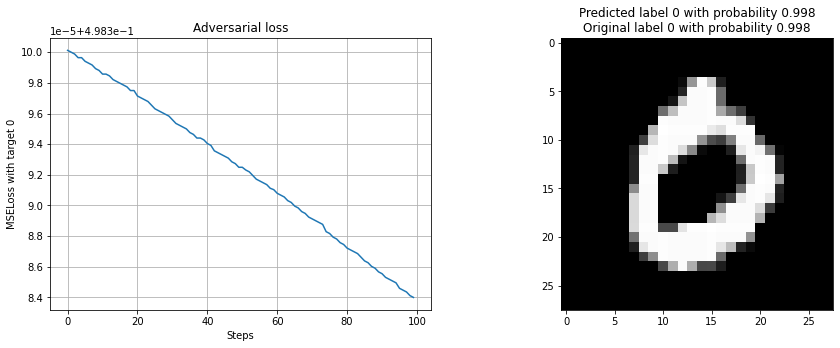

In [9]:
# Define loss function
loss = MSELoss(neuron=0, maximise=False)
# Define optimizer
optim = FrankWolfe(net, loss, device=device)

# Disable gradient computation
with torch.no_grad():
    # Run the optimizer
    x, loss_list, out_list = optim.run(
        # Input image
        x=X[3],
        # Set number of epochs
        num_epochs=100,
        # Weight of the momentum term wrt (estimated) gradient term
        m_weight=0.5,
        # Step size
        step_size=0.001,
        # L-infinity norm upper bound
        l_bound=1,
        # Gradeint estimation parameters
        grad_est='gaussian',  # Type of gradient estimation function
        grad_est_step=0.01,  # Step size used in gradient estimation
        grad_est_niter=1000,  # Number of inner loops for each gradient estimation
        # Wether to return either losses and outputs of the network
        ret_out=True,
        # Set verbose
        verbose=True
    )
    # Use output function to retrieve output class
    out = out_fn(net(x.reshape(1, 1, 28, 28)))
    # Get output label
    label_pred = torch.argmax(out).item()
    # Get output image
    img = x.detach().cpu().numpy()
    # Plot output image
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    _ = ax[0].plot(loss_list)
    _ = ax[0].set_title('Adversarial loss')
    _ = ax[0].set_ylabel('MSELoss with target 0')
    _ = ax[0].set_xlabel('Steps')
    _ = ax[0].grid()
    _ = ax[1].imshow(img.reshape(28, 28), cmap='gray')
    _ = ax[1].set_title(
        'Predicted label {:d} with probability {:.3f}\nOriginal label {:d} with probability {:.3f}'.format(
            int(label_pred),  # Predicted (attacked) image label
            float(out[0, label_pred]), # Predicted (attacked) image label probability
            int(label_true),  # True/original image label
            float(out[0, label_true]))  # True/original image label probability
    )
    _ = plt.show()